In [1]:
import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt

from mgc.independence import Dcorr
from mgc.sims import *

sys.path.append(os.path.realpath('..'))

In [2]:
import seaborn as sns
sns.color_palette('Set1')
sns.set(color_codes=True, style='white', context='talk', font_scale=2, palette="colorblind")

In [3]:
MAX_SAMPLE_SIZE = 101
STEP_SIZE = 5
SAMP_SIZES = range(20, MAX_SAMPLE_SIZE, STEP_SIZE)
POWER_REPS = 5

In [28]:
simulations = [
    linear,
    quadratic,
    spiral,
    multimodal_independence
]

cases = [
    1,
    2,
    3
]

In [5]:
from math import ceil

from scipy._lib._util import check_random_state, MapWrapper


class _ParallelP(object):
    """
    Helper function to calculate parallel power.
    """

    def __init__(self, case, sim, n, p, noise, rngs):
        self.case = case
        self.sim = sim

        self.n = n
        self.p = p
        self.noise = noise
        self.rngs = rngs

    def __call__(self, index):
        if (
            self.sim.__name__ == "multiplicative_noise"
            or self.sim.__name__ == "multimodal_independence"
        ):
            x, y = self.sim(self.n, self.p)
        else:
            x, y = self.sim(self.n, self.p, noise=self.noise)

        _, pvalue = Dcorr().test(x, y, case=self.case)

        return pvalue


def _perm_test(
    case, sim, n=100, p=1, noise=False, reps=1000, workers=1, random_state=None
):
    r"""
    Helper function that calculates the statistical.

    Parameters
    ----------
    test : callable()
        The independence test class requested.
    sim : callable()
        The simulation used to generate the input data.
    reps : int, optional (default: 1000)
        The number of replications used to estimate the null distribution
        when using the permutation test used to calculate the p-value.
    workers : int, optional (default: -1)
        The number of cores to parallelize the p-value computation over.
        Supply -1 to use all cores available to the Process.

    Returns
    -------
    null_dist : list
        The approximated null distribution.
    """
    # set seeds
    random_state = check_random_state(random_state)
    rngs = [
        np.random.RandomState(random_state.randint(1 << 32, size=4, dtype=np.uint32))
        for _ in range(reps)
    ]

    # use all cores to create function that parallelizes over number of reps
    mapwrapper = MapWrapper(workers)
    parallelp = _ParallelP(case, sim=sim, n=n, p=p, noise=noise, rngs=rngs)
    pval_dist = np.array(list(mapwrapper(parallelp, range(reps))))

    return pval_dist


def power(
    case,
    sim,
    n=100,
    p=1,
    noise=True,
    alpha=0.05,
    reps=1000,
    workers=1,
    random_state=None,
):
    """
    [summary]

    Parameters
    ----------
    test : [type]
        [description]
    sim : [type]
        [description]
    n : int, optional
        [description], by default 100
    p : int, optional
        [description], by default 1
    noise : int, optional
        [description], by default 0
    reps : int, optional
        [description], by default 1000
    alpha : float, optional
        [description], by default 0.05
    """

    pval_dist = _perm_test(
        case,
        sim,
        n=n,
        p=p,
        noise=noise,
        reps=reps,
        workers=workers,
        random_state=random_state,
    )
    empirical_power = np.where(pval_dist <= alpha)[0].shape[0] / reps

    return empirical_power


def power_sample(
    case,
    sim,
    n=100,
    p=1,
    noise=True,
    alpha=0.05,
    reps=100,
    workers=1,
    random_state=None,
):
    """
    [summary]

    Parameters
    ----------
    test : [type]
        [description]
    sim : [type]
        [description]
    n : int, optional
        [description], by default 100
    p : int, optional
        [description], by default 1
    noise : int, optional
        [description], by default 0
    reps : int, optional
        [description], by default 1000
    alpha : float, optional
        [description], by default 0.05
    """

    return power(
        case,
        sim,
        n=n,
        p=p,
        noise=noise,
        alpha=alpha,
        reps=reps,
        workers=workers,
        random_state=random_state,
    )


def power_dim(
    case,
    sim,
    n=100,
    p=1,
    noise=False,
    alpha=0.05,
    reps=100,
    workers=1,
    random_state=None,
):
    """
    hello

    Parameters
    ----------
    test : [type]
        [description]
    sim : [type]
        [description]
    n : int, optional
        [description], by default 100
    p : int, optional
        [description], by default 1
    noise : int, optional
        [description], by default 0
    reps : int, optional
        [description], by default 1000
    alpha : float, optional
        [description], by default 0.05
    """

    return power(
        case,
        sim,
        n=n,
        p=p,
        noise=noise,
        alpha=alpha,
        reps=reps,
        workers=workers,
        random_state=random_state,
    )


In [6]:
def find_dim(sim):
    if sim not in simulations:
        raise ValueError("Invalid simulation")
        
    if sim in [multimodal_independence]:
        dim = 100
    elif sim in [linear]:
        dim = 1000
    else:
        dim = 20
        
    return dim

def find_dim_range(dim):
    if dim < 20:
        lim = 10
    else:
        lim = 20
    
    dim_range = list(range(int(dim/lim), dim+1, int(dim/lim)))
    if int(dim/lim) != 1:
        dim_range.insert(0, 1)
    return dim_range

In [9]:
def estimate_power(sim, case):
    est_power = np.array([np.mean([power_sample(case, sim, n=i) for _ in range(POWER_REPS)])
                          for i in SAMP_SIZES])
    np.savetxt('fasttest_vs_samplesize/{}_{}.csv'.format(sim.__name__, case),
               est_power, delimiter=',')
    dim = find_dim(sim)
    dim_range = find_dim_range(dim)
    est_power = np.array([np.mean([power_dim(case, sim, p=dim) for _ in range(POWER_REPS)])
                          for dim in dim_range])
    np.savetxt('fasttest_vs_dimension/{}_{}.csv'.format(sim.__name__, case),
               est_power, delimiter=',')
    
    return est_power

In [10]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, case) for sim in simulations for case in cases]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  2.6min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  2.6min remaining:  4.4min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:  2.7min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  3.1min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:  3.1min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.6min finished


In [31]:
def plot_power_sampsize():
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(14,4))
    
    sim_title = [
        "Linear",
        "Quadratic",
        "Spiral",
        "Independence"
    ]
    
    for i, col in enumerate(ax):
        sim = simulations[i]

        for case in cases:
            power = np.genfromtxt('fasttest_vs_samplesize/{}_{}.csv'.format(sim.__name__, case),
                                  delimiter=',')

            col.plot(SAMP_SIZES, power, label=case, lw=3)
            col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
            col.set_ylim(0, 1.2)
            col.set_yticks([])
            if i == 0:
                col.set_yticks([0, 1])
            col.set_title(sim_title[i])
    
    fig.text(0.5, -0.15, 'Increasing Sample Size', ha='center')
    fig.text(0.02, 0.5, '       Absolute\n Statistical Power', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, -0.1), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)

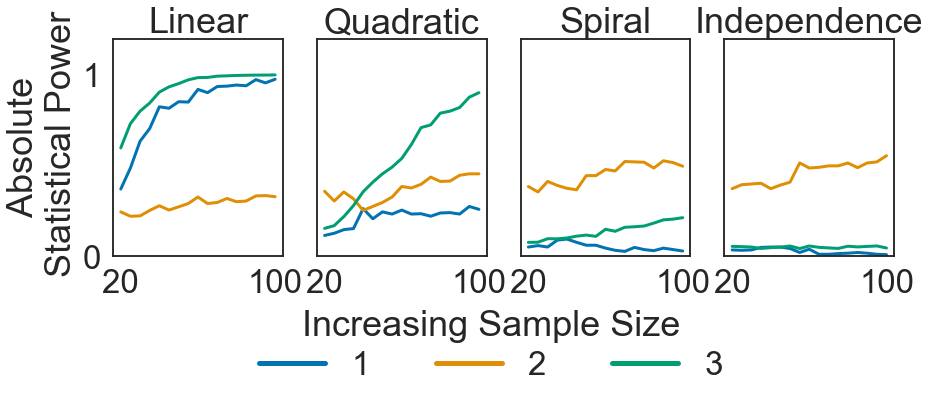

In [32]:
plot_power_sampsize()

In [38]:
def plot_power_dimension():
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(14,4))
    
    sim_title = [
        "Linear",
        "Quadratic",
        "Spiral",
        "Independence"
    ]
    
    for i, col in enumerate(ax):
        sim = simulations[i]

        for case in cases:
            power = np.genfromtxt('fasttest_vs_dimension/{}_{}.csv'.format(sim.__name__, case),
                                  delimiter=',')
            dim_range = find_dim_range(find_dim(sim))
            col.plot(dim_range, power, label=case, lw=3)
            col.set_xticks([dim_range[0], dim_range[-1]])
            col.set_ylim(0, 1.2)
            col.set_yticks([])
            if i == 0:
                col.set_yticks([0, 1])
            col.set_title(sim_title[i])
    
    fig.text(0.5, -0.15, 'Increasing Sample Size', ha='center')
    fig.text(0.02, 0.5, '       Absolute\n Statistical Power', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, -0.1), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)

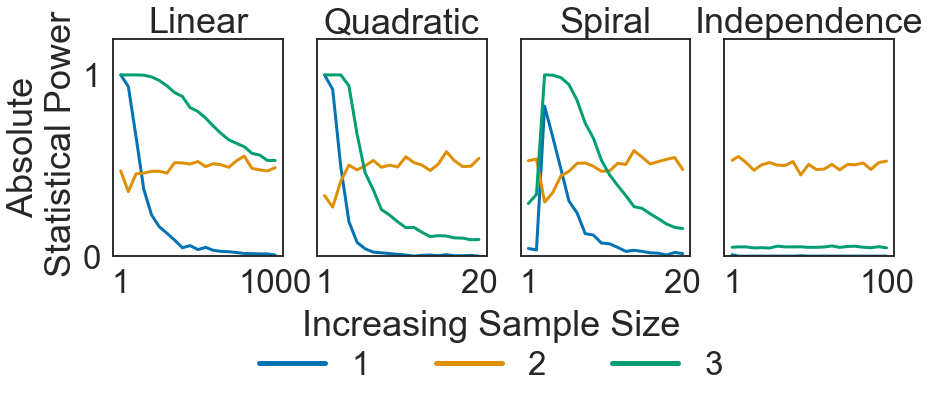

In [39]:
plot_power_dimension()